# Solution

In [134]:
import numpy as np
from solvers import solver
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate
from IPython.display import display
from scipy.signal import argrelextrema
import time
import psutil
import os

pid = os.getpid()
psutil.Process(pid).cpu_affinity([0]) # limit process to first core so that execution time is more accurate

## Implementation

The following code section implements the solvers.py functions with the perameters, inital conditions, and functions...

In [135]:
def Euler_method(function, d0, t0, dt, T):
    n = int(T / dt)
    d = np.zeros((n + 1, len(d0)))
    d[0] = d0
    t = np.zeros(n + 1)
    for i in range(n + 1):
        t[i] = t0 + i * dt

    for i in range(1, n + 1):
        d[i] = d[i - 1] + dt * function(t[i - 1], d[i - 1])
    return t, d

def rhsA(t, z): # function for the rhs of the first system of ODEs
    def f(t):
        x = -np.sin(t) - np.cos(t)**2 - np.cos(t)
        return x

    def g(t):
        x = np.sin(t) + np.cos(t)**2 - np.cos(t)
        return x
    
    xt = z[0] - (z[1] * z[0]) + f(t)
    yt = (z[0] * z[1]) - z[1] + g(t)
    return np.array([xt, yt])

    
def rhsB(t, z) : # function for the rhs of the second system of ODEs
    a = 2/3
    b = 4/3
    c = 1
    d = 1
    
    xt = a*z[0] - b*z[1]*z[0]
    yt = c*z[0]*z[1] - d*z[1]
    return np.array([ xt , yt])

def runA(name, T, dt):

    z0 = np. array ([2.0 , 0.0])
    t0 = 0.0
    if name == 'Euler': # special case for Euler method as it is not in the solver function
         t, z = Euler_method(rhsA, z0, t0, dt, T)
    else:
        t, z = solver (rhsA , z0 , t0 , dt , T, name)
    x = [elem[0] for elem in z]
    y = [elem[1] for elem in z]

    return x, y, t

def runB(name, T, dt):
    z0 = np. array ([0.9, 0.9])
    t0 = 0.0
    if name == 'Euler':
         t, z = Euler_method(rhsB, z0, t0, dt, T)
    else:
        t, z = solver (rhsB , z0 , t0 , dt , T, name)
    x = [elem[0] for elem in z]
    y = [elem[1] for elem in z]
    
    return x, y, t


The following code works to generate exact solutions for comparison for Case A

In [136]:

def exactA(T, dt):
    t = np.arange(0, T+dt, dt)
    x = 1 + np.cos(t)
    y = 1 - np.cos(t)
    return x, y, t

def getAllExact(T, dt): # get exact solution for all dt
    x_exact = []
    y_exact = []
    t_exact = []
    for i in range(len(dt)):
        x, y, t = exactA(T, dt[i])
        x_exact.append(x)
        y_exact.append(y)
        t_exact.append(t)
    return x_exact, y_exact, t_exact


The following code works to calculate maxima data for comparison for Case B

In [137]:
def find_maxima_indices_single_dt(array):
    # array is flattened so that argrelextrema can find the maxima
    flat_array = np.ravel(array)
    
    # Find indices of local maxima
    maxima_indices = argrelextrema(flat_array, np.greater)
    
    # flatten the result, as argrelextrema returns a tuple of arrays
    maxima_indices = np.concatenate(maxima_indices)
    
    return maxima_indices

# method to find maxima indecies for x and y for each dt
def find_maxima_indices_many_dt(x, y):
    maxima_x = []
    maxima_y = []
    for i in range(len(x)):
        maxima_x.append(find_maxima_indices_single_dt(x[i]))
        maxima_y.append(find_maxima_indices_single_dt(y[i]))
    return maxima_x, maxima_y


The following code contains methods for presenting the generated data

In [138]:
def plot_solutions_for_dt(x_values, y_values, t_values, dt_values, method_names, case_name):
    num_dt = len(dt_values)
    num_plots_per_row = 2
    num_rows = (num_dt + num_plots_per_row - 1) // num_plots_per_row
    fig, axs = plt.subplots(num_rows, num_plots_per_row, figsize=(18, 5*num_rows))

    # Flatten the array for easy indexing
    axs = axs.flatten()

    for i in range(num_dt):
        ax = axs[i]
        for j in range(len(x_values)):
            ax.plot(t_values[j][i], x_values[j][i], label=f'{method_names[j]} - Prey')
            ax.plot(t_values[j][i], y_values[j][i], label=f'{method_names[j]} - Predator')

        ax.set_title(f'Solutions for Different Methods (dt={dt_values[i]:.5f}) for {case_name}')
        ax.set_xlabel('Time (t)')
        ax.set_ylabel('Population')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True)

    # Remove extra subplots
    for i in range(num_dt, len(axs)):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.show()


def plot_errors(errors, T, name):
    plt.figure(figsize=(20, 6))

    # plot for Prey
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot number 1
    for i in range(5):
        plt.plot(errors[i][2], errors[i][0], label=f'Absolute Error for Prey dt={T/(100*(2**i))}')
    plt.title('Absolute Errors for different timesteps (Prey) using method: %s' % name)
    plt.xlabel('Timestep (t)')
    plt.ylabel('Absolute Error')
    plt.legend()

    # plot for Predator
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, plot number 2
    for i in range(5):
        plt.plot(errors[i][2], errors[i][1], label=f'Absolute Error for Predator dt={T/(100*(2**i))}')
    plt.title('Absolute Errors for different timesteps (Predator) using method: %s' % name)
    plt.xlabel('Timestep (t)')
    plt.ylabel('Absolute Error')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_mean_error_tables(mean_error_tables, method_names):
    plt.figure(figsize=(12, 8))

    # plot for Prey
    plt.subplot(2, 1, 1)  # 2 rows, 1 column, plot number 1
    for i, mean_error_table in enumerate(mean_error_tables):
        plt.plot(mean_error_table['dt'], mean_error_table['Prey Mean Abs Error'], marker='o', linestyle='-', label=f'{method_names[i]} - Prey')
    plt.title('Mean Absolute Errors for Prey')
    plt.xlabel('Timestep (dt)')
    plt.ylabel('Absolute Error')
    plt.xscale('log')  # log scale for better visibility
    plt.yscale('log')
    plt.xticks(mean_error_tables[0]['dt'], [f"{dt:.5f}" for dt in mean_error_tables[0]['dt']])
    plt.legend()
    plt.gca().invert_xaxis()

    # plot for Predator
    plt.subplot(2, 1, 2)  # 2 rows, 1 column, plot number 2
    for i, mean_error_table in enumerate(mean_error_tables):
        plt.plot(mean_error_table['dt'], mean_error_table['Predator Mean Abs Error'], marker='o', linestyle='-', label=f'{method_names[i]} - Predator')
    plt.title('Mean Absolute Errors for Predator')
    plt.xlabel('Timestep (dt)')
    plt.ylabel('Absolute Error')
    plt.xscale('log')  # log scale for better visibility
    plt.yscale('log')
    plt.xticks(mean_error_tables[0]['dt'], [f"{dt:.5f}" for dt in mean_error_tables[0]['dt']])
    plt.legend()
    plt.gca().invert_xaxis()

    plt.tight_layout()
    plt.show()

def print_mean_error_table(mean_error_table, name):
    print(f"Mean Absolute Errors for {name}")
    table = tabulate(mean_error_table, headers='keys', tablefmt='grid', showindex=False)
    print(table)

def print_maxima_data_x(maxima_x, maxima_y, t, x, y, T, name):
    table_data = []
    for i in range(len(maxima_x)):
        if i == 0 or i == len(maxima_x) - 1:  
            dt = T / (100 * 2**i)
            prey_values = []  # list to store prey_values for each dt
            for j in range(len(maxima_x[i])):
                maxima_num = j + 1
                maxima_time = t[i][maxima_x[i][j]]
                prey_value = x[i][maxima_x[i][j]]
                prey_values.append(prey_value)  # append each prey_value to the list
                table_data.append([f"Maxima {maxima_num}", f"t = {maxima_time:.5f}", f"Prey = {prey_value:.5f}"])
            # calculate the standard deviation of the prey_values for each dt
            std_dev = np.std(prey_values)
            table_data.append([f"dt = {dt:.5f}", f"Standard Deviation = {std_dev:.5f}", ''])
            table_data.append(['', '', ''])

    table = tabulate(table_data, headers=['', '', ''], tablefmt='grid')
    title = f"Maxima Data for {name} (Prey)"

    print(f"\n{title}\n{table}")


def print_maxima_data_y(maxima_x, maxima_y, t, x, y, T, name):
    table_data = []
    for i in range(len(maxima_y)):
        if i == 0 or i == len(maxima_y) - 1:  
            dt = T / (100 * 2**i)
            predator_values = []  # list to store predator_values for each dt
            for j in range(len(maxima_y[i])):
                maxima_num = j + 1
                maxima_time = t[i][maxima_y[i][j]]
                predator_value = y[i][maxima_y[i][j]]
                predator_values.append(predator_value)  # append each predator_value to the list
                table_data.append([f"Maxima {maxima_num}", f"t = {maxima_time:.5f}", f"Predator = {predator_value:.5f}"])
            # calculate the standard deviation of the predator_values for each dt
            std_dev = np.std(predator_values)
            table_data.append([f"dt = {dt:.5f}", f"Standard Deviation = {std_dev:.5f}", ''])
            table_data.append(['', '', ''])

    table = tabulate(table_data, headers=['', '', ''], tablefmt='grid')
    title = f"Maxima Data for {name} (Predator)"

    print(f"\n{title}\n{table}")

def plot_all_execution_times(execution_times, method_names):
    plt.figure(figsize=(12, 8))

    for i, execution_time in enumerate(execution_times):
        x_values = np.array([100 * (2**i) for i in range(5)])
        y_values = np.array(execution_time)
        
        # apply logarithmic transformation to x-values
        log_x_values = np.log2(x_values)
        log_y_values = np.log2(y_values)

        # perform linear regression on log-transformed data
        # needed as I am plotting on a log scale and want to show the gradient
        slope, intercept = np.polyfit(log_x_values, log_y_values, 1)

        # Plot the data points
        plt.plot(x_values, y_values, marker='o', linestyle='-', label=f'{method_names[i]}')

        # plot the regression line on the original x-axis scale
        regression_line = slope * log_x_values + intercept
        plt.plot(x_values, 2**regression_line, linestyle='--', color='gray', alpha=0.5)

        # display the gradient on the plot
        x_text, y_text = x_values[-1], 2**regression_line[-1]  # convert the y-coordinate back from log scale
        plt.annotate(f'Gradient: {slope:.4f}', (x_text, y_text),
                     textcoords="offset points", xytext=(-60, 10), ha='center', fontsize=8, color='gray')

    plt.title('Average Execution Time for different timesteps')
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Execution Time (s)')
    plt.legend()
    plt.grid(True)
    plt.show()


The following methods neatly return all the data needed to plot and display relevant test data

In [139]:
def testA(name):
    T = np.pi * 2.5
    errors = {}
    mean_errors = {'dt': [], 'Prey': [], 'Predator': []}
    x_values, y_values, t_values, execution_times = [], [], [], []

    for i in range(5):
        dt = T / (100 * (2**i))
        exactX, exactY, t = exactA(T, dt)

        # run the simulation 50 times to get average execution time
        total_execution_time = 0
        for _ in range(50):
            start_time = time.perf_counter()
            x, y, t = runA(name, T, dt)
            end_time = time.perf_counter()
            elapsed_time = end_time - start_time
            total_execution_time += elapsed_time

        # calculate average execution time
        avg_execution_time = total_execution_time / 50
        execution_times.append(avg_execution_time)

        x_values.append(x)
        y_values.append(y)
        t_values.append(t)

        data = {'Prey': x, 'Predator': y, 't': t}
        df = pd.DataFrame(data)

        # calculate absolute for each dt
        absolute_error_x = np.abs(x - exactX)
        absolute_error_y = np.abs(y - exactY)

        mean_errors['dt'].append(dt)
        mean_errors['Prey'].append(np.mean(absolute_error_x))
        mean_errors['Predator'].append(np.mean(absolute_error_y))

        # create a DataFrame for errors
        error_data = {'Absolute Error X': absolute_error_x,
                      'Absolute Error Y': absolute_error_y}
        error_df = pd.DataFrame(error_data)

        errors[i] = (absolute_error_x, absolute_error_y, t)

    mean_error_table = pd.DataFrame(mean_errors)
    mean_error_table.columns = ['dt', 'Prey Mean Abs Error', 'Predator Mean Abs Error']

    return mean_error_table, x_values, y_values, t_values, errors, execution_times, T

def testB(name):
    T = 30
    x_values, y_values, t_values, execution_times = [], [], [], []

    for i in range(5):
        dt = T / (100 * (2**i))

        # run the simulation 50 times
        total_execution_time = 0
        for _ in range(50):
            start_time = time.perf_counter()
            x, y, t = runB(name, T, dt)
            stop_time = time.perf_counter()
            elapsed_time = stop_time - start_time
            total_execution_time += elapsed_time

        # calculate average execution time
        avg_execution_time = total_execution_time / 50
        execution_times.append(avg_execution_time)

        x_values.append(x)
        y_values.append(y)
        t_values.append(t)

        data = {'Prey': x, 'Predator': y, 't': t}
        df = pd.DataFrame(data)

    return x_values, y_values, t_values, execution_times, T

## Results

For Case A, I used $T = 2.5\pi$ and $\mathrm{d}t = T/100, T/200, T/400, T/800, T/1600$. 

For Case B, I used $T = 30$ and $\mathrm{d}t = T/100, T/200, T/400, T/800, T/1600$.

Results, accuracy and efficiency are discussed in the next sections.


### Case A Results

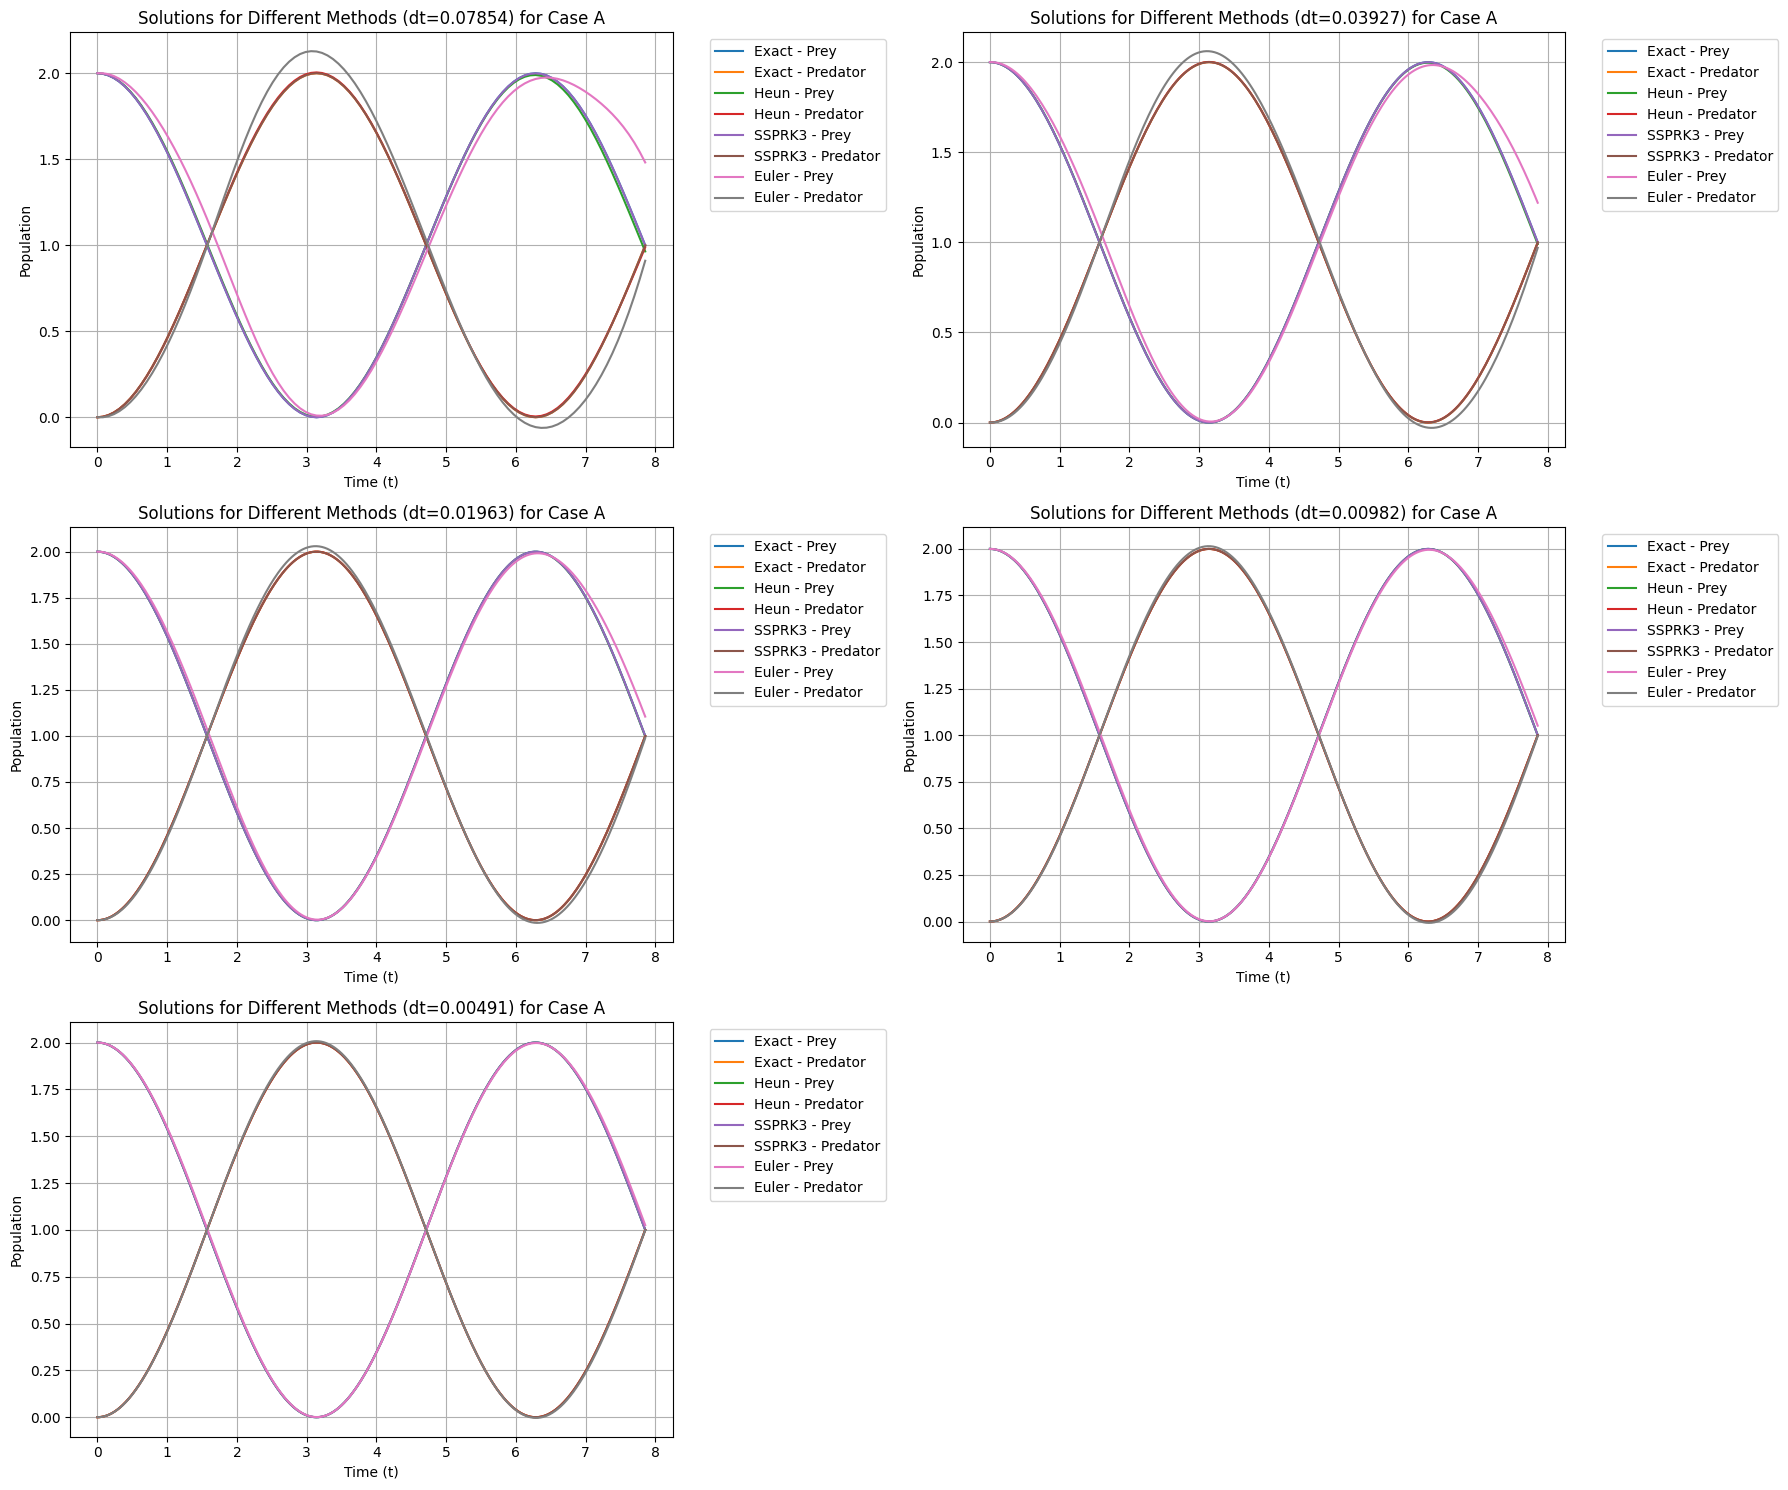

Mean Absolute Errors for Heun
+------------+-----------------------+---------------------------+
|         dt |   Prey Mean Abs Error |   Predator Mean Abs Error |
+============+=======================+===========================+
| 0.0785398  |           0.00859545  |               0.00356547  |
+------------+-----------------------+---------------------------+
| 0.0392699  |           0.00227528  |               0.000935872 |
+------------+-----------------------+---------------------------+
| 0.019635   |           0.000583899 |               0.000239434 |
+------------+-----------------------+---------------------------+
| 0.00981748 |           0.000147805 |               6.05327e-05 |
+------------+-----------------------+---------------------------+
| 0.00490874 |           3.71762e-05 |               1.52169e-05 |
+------------+-----------------------+---------------------------+
Mean Absolute Errors for SSPRK3
+------------+-----------------------+---------------------------+


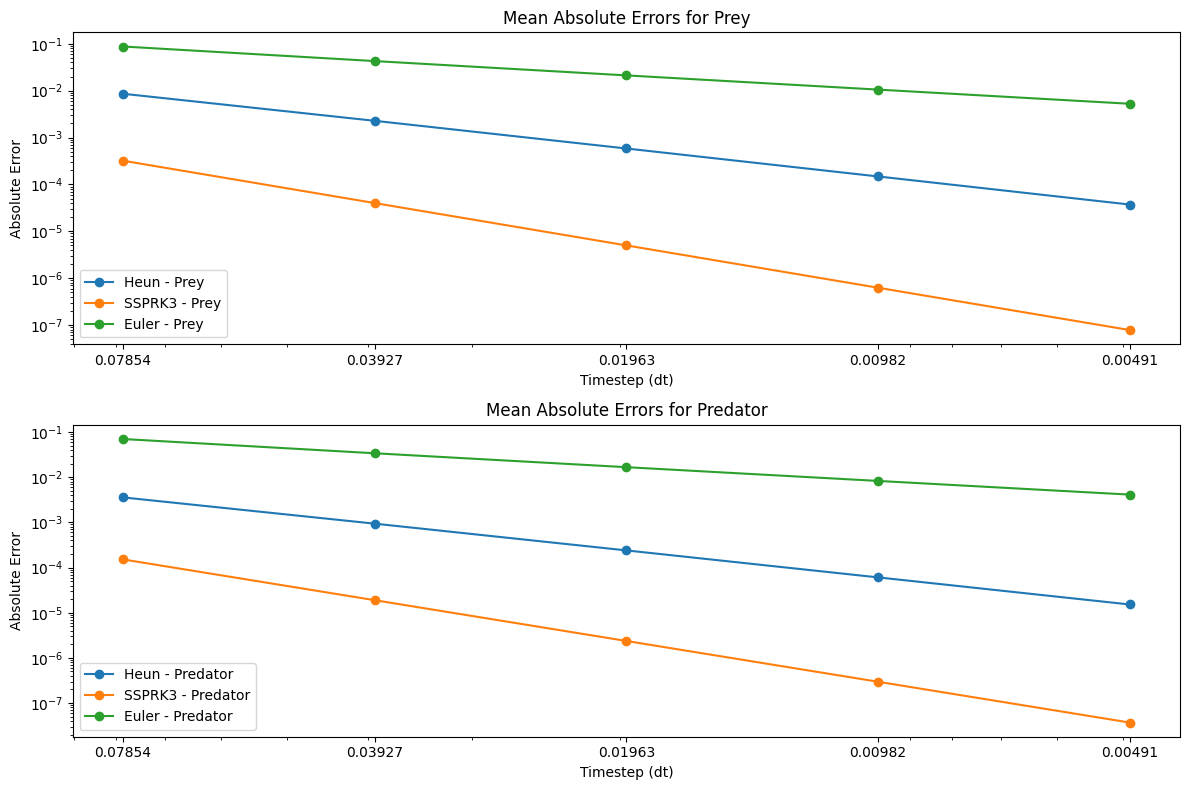

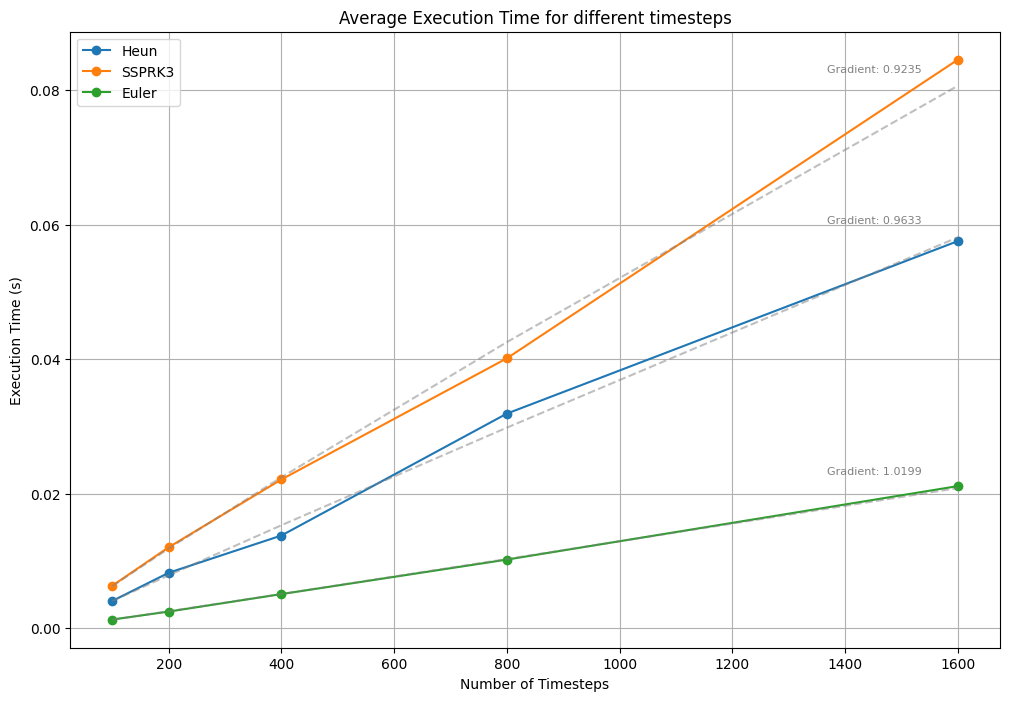

In [140]:
#for case A
exact_x, exact_y, exact_t = getAllExact(2.5 * np.pi, [2.5 * np.pi / (100 * 2**i) for i in range(5)])  # get exact solutions for all dt values
mean_heun_errors, heun_x, heun_y, heun_t, heun_errors, heun_execution, heun_T = testA("Heun")
mean_ssprk3_errors, ssprk3_x, ssprk3_y, ssprk3_t, ssprk3_errors, ssprk3_execution, ssprk3_T = testA("SSPRK3")
mean_euler_errors, euler_x, euler_y, euler_t, euler_errors, euler_execution, euler_T = testA("Euler")


plot_solutions_for_dt([exact_x, heun_x, ssprk3_x, euler_x],
                        [exact_y, heun_y, ssprk3_y, euler_y],
                        [exact_t, heun_t, ssprk3_t, euler_t],
                        [2.5 * np.pi / (100 * 2**i) for i in range(5)],
                        ["Exact", "Heun", "SSPRK3", "Euler"],"Case A")

print_mean_error_table(mean_heun_errors, "Heun")
print_mean_error_table(mean_ssprk3_errors, "SSPRK3")
print_mean_error_table(mean_euler_errors, "Euler")

# pass the max_error_tables and corresponding method names to the plotting function
plot_mean_error_tables([mean_heun_errors, mean_ssprk3_errors, mean_euler_errors], ["Heun", "SSPRK3", "Euler"])

plot_all_execution_times([heun_execution, ssprk3_execution, euler_execution], ["Heun", "SSPRK3", "Euler"])

### Case B Results

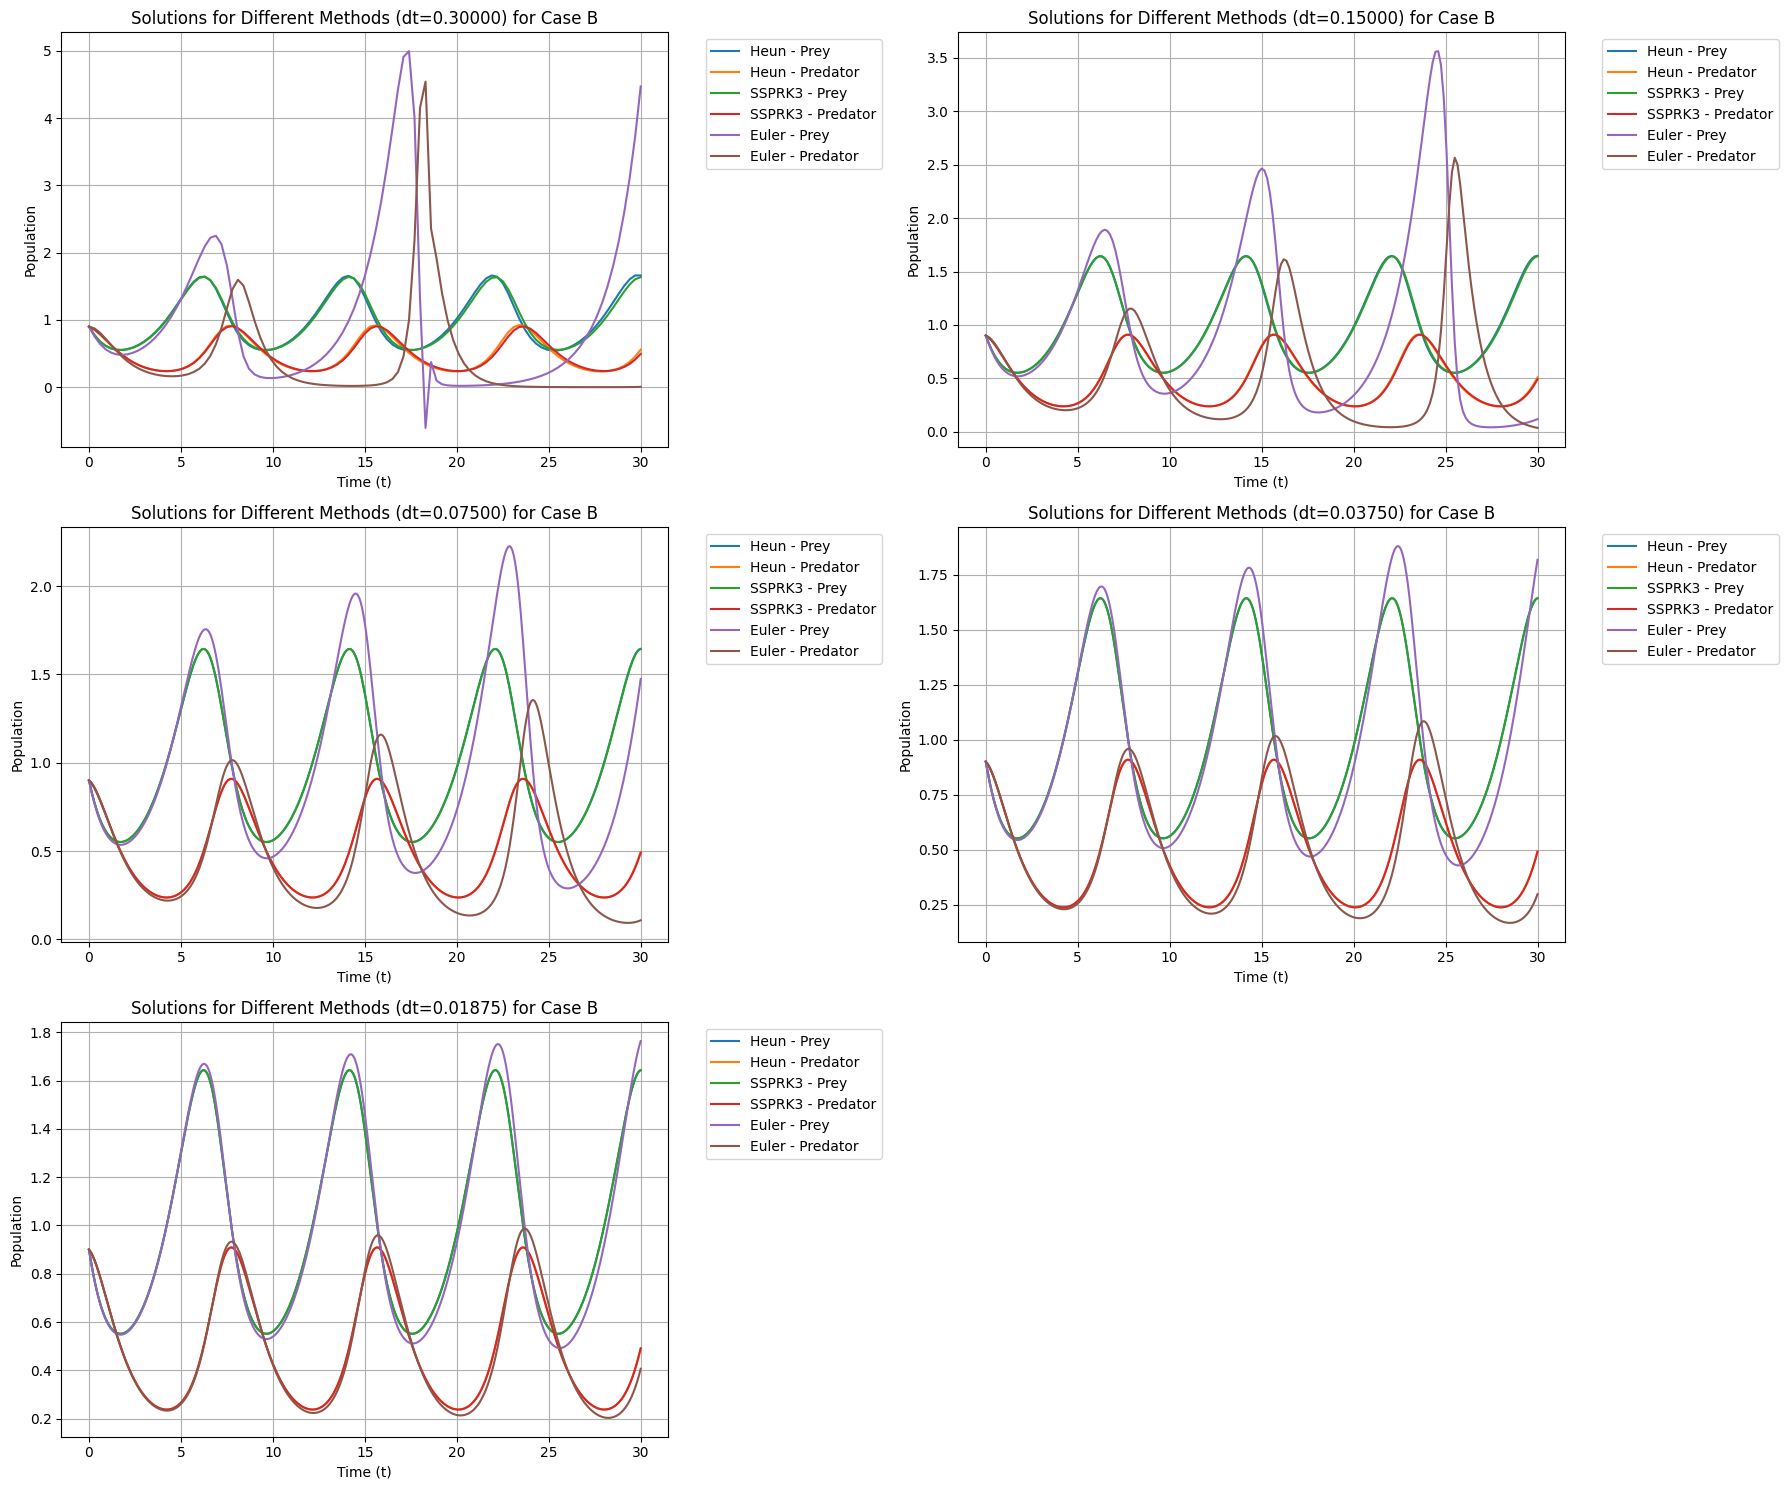


Maxima Data for Heun (Prey)
+--------------+------------------------------+----------------+
|              |                              |                |
+==============+==============================+================+
| Maxima 1     | t = 6.30000                  | Prey = 1.64499 |
+--------------+------------------------------+----------------+
| Maxima 2     | t = 14.10000                 | Prey = 1.65519 |
+--------------+------------------------------+----------------+
| Maxima 3     | t = 21.90000                 | Prey = 1.66083 |
+--------------+------------------------------+----------------+
| Maxima 4     | t = 29.70000                 | Prey = 1.66116 |
+--------------+------------------------------+----------------+
| dt = 0.30000 | Standard Deviation = 0.00654 |                |
+--------------+------------------------------+----------------+
|              |                              |                |
+--------------+------------------------------+--------------

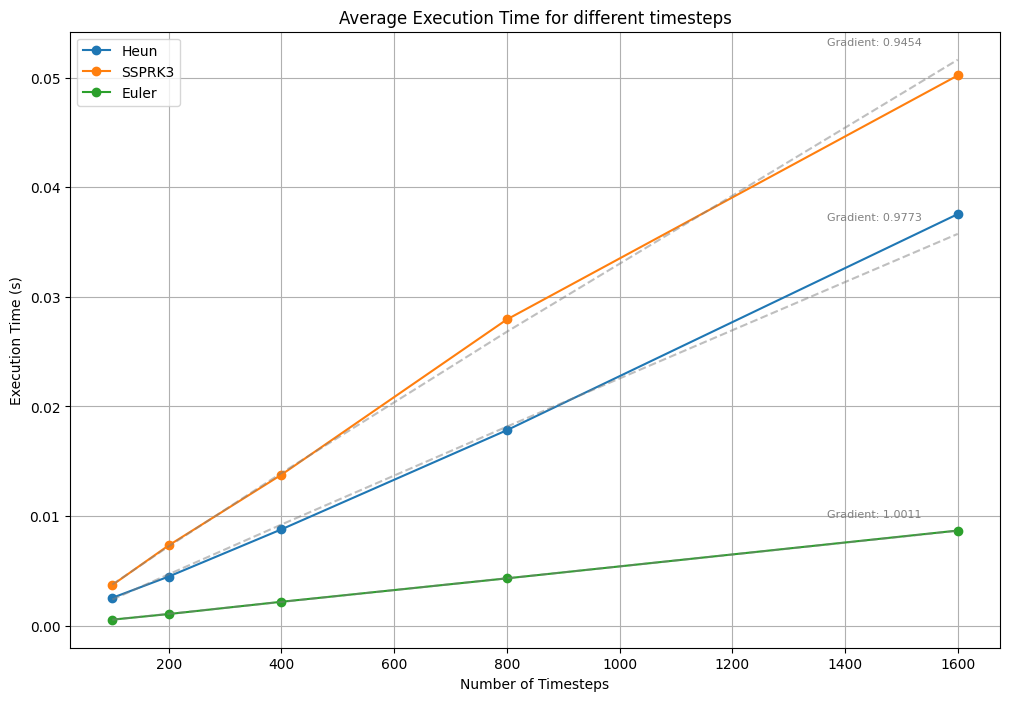

In [141]:
#for case B
heun_x, heun_y, heun_t, heun_execution, heun_T = testB("Heun")
ssprk3_x, ssprk3_y, ssprk3_t, ssprk3_execution, ssprk3_T = testB("SSPRK3")
euler_x, euler_y, euler_t, euler_execution, euler_T = testB("Euler")

plot_solutions_for_dt([heun_x, ssprk3_x, euler_x],
                        [heun_y, ssprk3_y, euler_y],
                        [heun_t, ssprk3_t, euler_t],
                        [30 / (100 * 2**i) for i in range(5)],
                        ["Heun", "SSPRK3", "Euler"],"Case B")

heun_maxima_x, heun_maxima_y = find_maxima_indices_many_dt(heun_x, heun_y)
ssprk3_maxima_x, ssprk3_maxima_y = find_maxima_indices_many_dt(ssprk3_x, ssprk3_y)
euler_maxima_x, euler_maxima_y = find_maxima_indices_many_dt(euler_x, euler_y)


    
print_maxima_data_x(heun_maxima_x, heun_maxima_y, heun_t, heun_x, heun_y, heun_T, "Heun")
print_maxima_data_y(heun_maxima_x, heun_maxima_y, heun_t, heun_x, heun_y, heun_T, "Heun")

print_maxima_data_x(ssprk3_maxima_x, ssprk3_maxima_y, ssprk3_t, ssprk3_x, ssprk3_y, ssprk3_T, "SSPRK3")
print_maxima_data_y(ssprk3_maxima_x, ssprk3_maxima_y, ssprk3_t, ssprk3_x, ssprk3_y, ssprk3_T, "SSPRK3")

print_maxima_data_x(euler_maxima_x, euler_maxima_y, euler_t, euler_x, euler_y, euler_T, "Euler")
print_maxima_data_y(euler_maxima_x, euler_maxima_y, euler_t, euler_x, euler_y, euler_T, "Euler")

plot_all_execution_times([heun_execution, ssprk3_execution, euler_execution], ["Heun", "SSPRK3", "Euler"])

## Analysis

#### Graphical Analysis:
For Case A, as the timestep (dt) decreases, the numerical solutions generated by Heun's method, SSPRK3, and Euler's method tend to converge towards the exact solution. The graphical plots illustrate the convergence, showing a close alignment of the solutions for the smallest timestep, indicating improved accuracy. By the final timestep (2.5*pi / 1600), the plotted solutions mostly overlap with one another. 

In Case B, for larger timesteps, the graphical plots exhibit sporadic behavior, indicating potential instability or inconsistency in the solutions. As the time step decreases, all methods show improved consistency, and the solutions tend to converge, especially in the behavior of maxima. The behavior is more pronounced in the prey population, while the predator population shows larger inconsistencies, particularly for Euler's method.

#### Method Order:
The graphical and error analysis align with the expected behavior based on the order of each method. Heun's method and SSPRK3, being higher-order methods, display superior accuracy compared to Euler's method, which is a first-order method. The order of a numerical method indicates how quickly the error decreases with decreasing time step, explaining the observed differences.

| Method Name | Order | Error Proportionality as $dt \rightarrow 0$ |
| --- | --- | --- |
| Euler's | $1^{st}$ | $O(dt)$ |
| Heun's | $2^{nd}$ | $O(dt^2)$ |
| SSPRK3 | $3^{rd}$ | $O(dt^3)$ |

#### Error Analysis:
For Case A, the mean absolute errors for all methods decrease as the timestep ($dt$) becomes smaller. The error reduction is consistent with the expected behavior, with Heun's method and SSPRK3 exhibiting lower error values compared to Euler's method for the same timestep. The choice of mean absolute error provides a quantitative measure of accuracy, emphasizing the reduction in discrepancies between numerical and exact solutions.

## Conclusion

### Computational Efficiency

The methods exhibit linear time complexity ($O(N)$), as indicated by a gradient of approximately $1.00$ on the execution time graph. In both Case A and B, SSPRK3 proves the most computationally expensive, while Euler's method is the least costly. The analysis is based on average execution times over 50 iterations, each restricted to a single core to minimize external variables. It's important to note that execution times can still be influenced by factors like system load and operating system tasks. [Reference (UC San Diego - Algorithm Time Cost Measurement)](https://web.archive.org/web/20231219202905/https://cseweb.ucsd.edu/~kube/cls/12.s13/Lectures/lec06/lec06.pdf)

#### Accuracy:
For Case A, Heun's method and SSPRK3 demonstrate higher accuracy, aligning with their higher-order nature. Euler's method, while computationally less expensive, lags in accuracy. For the smallest timestep, the size of their mean absolute errors can be seen to be in different magnitudes, with the abs. error of SSPRK3 being $10^{-8}$; Heun's at $10^{-5}$; and Euler's at $10^{-3}$.


Case B emphasises the significance of using smaller time steps for consistency across methods. Euler's method displays larger inconsistencies compared to Heun's method and SSPRK3. In examining the maxima data, crucial for maintaining consistency, Euler's method notably lags behind. Even on the smallest timestep, Euler's solution diverges visibly, with standard deviations for predator and prey solutions at $0.02233$ and $0.03342$, respectively. In contrast, SSPRK3 and Heun exhibit consistent results with standard deviations of $0$ for both predator and prey solutions on the smallest timestep.

#### Where did it all go wrong for Euler's method?
Euler's method faced significant issues, particularly with the largest timestep tested. The use of trigonometric functions, such as $sin(t)$ and $cos(t)$, caused inaccuracies and implausible results. Rapid oscillations within each step led to inaccuracies, especially when the timestep ($dt$) was large. This resulted in erratic behavior and negative values for populations, like in Case B at $t=18.3$ where the prey population was calculated as $-0.605383$.

#### Recommendation:
I recommend employing Heun's method based on its favorable balance of accuracy, stability, and computational efficiency. In Case A, SSPRK3 exhibits the smallest mean absolute error but has significantly longer execution times. In Case B, both SSPRK3 and Heun's method show consistent accuracy, but Heun's method proves to be more efficient. Therefore, Heun's method stands out as a well-rounded choice, meeting the desired criteria while considering computational costs.